# Problema: Transferencia de Calor - Conducción en pared 1D

### Cargo Librerias

In [ ]:
# Monta carpetas de drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# Cargando Requirements
!pip install -r "/content/drive/MyDrive/Taller PINNs/Clase_3/requirements.txt"
# Librerias utiles

# Importo libreriras
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import imageio
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output # lo usamos para que el gráfico se refresque y no te llene la pantalla de miles de gráficos.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 107.8 MB/s eta 0

## Cargo datos

In [ ]:
## Inicializo la semilla
random_seed =  1234 # Semilla fija (1234) que se utiliza para controlar la aleatoriedad.
torch.manual_seed(random_seed) # Inicia la semilla que afecta selección de pesos de la red.
                               # Resultados de torch.rand, torch.randn, etc.
                               # Orden aleatorio en datasets con DataLoader(..., shuffle=True).

## Cargo dataset
relative_csv_path = "/content/drive/MyDrive/Taller PINNs/Clase_3/heat_transfer_finn.csv"
split_ratio = 0.2

# Organizo y cargo los diferentes parámetros del dataset
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields_G = ['G']
fields = fields_T + fields_G
df = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
print(df)
df_train, df_test = train_test_split(df, test_size = split_ratio, random_state=random_seed)

# Genero numpy array para organizar datos
X_train, Y_train = (df_train[fields_T].to_numpy(), df_train[fields_G].to_numpy())
X_test, Y_test = (df_test[fields_T].to_numpy(), df_test[fields_G].to_numpy())

# Muestro el formato de los datos
print("X_test information:")
print("the size of X_test is", X_test.size)
print("the shape of X_test is", X_test.shape)

print("X_train information:")
print("the size of X_train is", X_train.size)
print("the shape of X_train is", X_train.shape)

print("Y_train information:")
print("the size of Y_train is", Y_train.size)
print("the shape of Y_train is", Y_train.shape)

print("Y_test information:")
print("the size of Y_test is", Y_test.size)
print("the shape of Y_test is", Y_test.shape)

            G     T1          T2          T3          T4          T5  \
0    0.466437  400.0  398.302558  396.849679  395.634729  394.650520   
1    0.789417  400.0  402.069952  403.829778  405.295777  406.479782   
2    0.618756  400.0  400.043948  400.079881  400.109876  400.134140   
3    0.333827  400.0  396.835856  394.124136  391.853177  390.011353   
4    0.523496  400.0  398.947667  398.047075  397.294456  396.685089   
..        ...    ...         ...         ...         ...         ...   
495  0.123213  400.0  394.596808  389.955218  386.059564  382.894421   
496  0.456705  400.0  398.193376  396.646939  395.353611  394.305818   
497  0.714528  400.0  401.170945  402.166938  402.997402  403.668602   
498  0.290461  400.0  396.365902  393.249919  390.639195  388.521015   
499  0.337020  400.0  396.870644  394.188831  391.942996  390.121600   

             T6          T7          T8          T9  
0    393.891157  393.352043  393.029891  392.922726  
1    407.391204  408.037205

### Funciones de normalización

### $\overline{\theta[i,j]}=2\frac{\theta[i,j]-\min(\theta[:, j]) }{\max(\theta[:,j]) - \min(\theta[:,j]) } - 1$

In [ ]:
def normalize_ij(xi, xmin, xmax):
    "Function to normalize a value xi given xmax and xmin boundaries"
    return 2 * (xi - xmin) / (xmax - xmin) - 1

def normalize(X_array, min_X_cols, max_X_cols):
    """
    Normalize an array by columns given a max and min of each column.

    Parameters:
    X_array(numpy array): Array to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_array.shape
    normalized_X_array = np.zeros_like(X_array)

    # Fill the copy vector
    for col in range(num_col_X):
      for row in range(num_row_X):
        normalized_X_array[row,col] = normalize_ij(X_array[row,col], min_X_cols[col], max_X_cols[col])

    return normalized_X_array

def max_min_by_columns(X_array):
    # Compute the min max vector
    (num_row_X, num_col_X) = X_array.shape
    min_col_X = [np.min(X_array[:,col_X]) for col_X in range(num_col_X)]
    max_col_X = [np.max(X_array[:,col_X]) for col_X in range(num_col_X)]
    return min_col_X, max_col_X

### Gráficas para análisis de datos

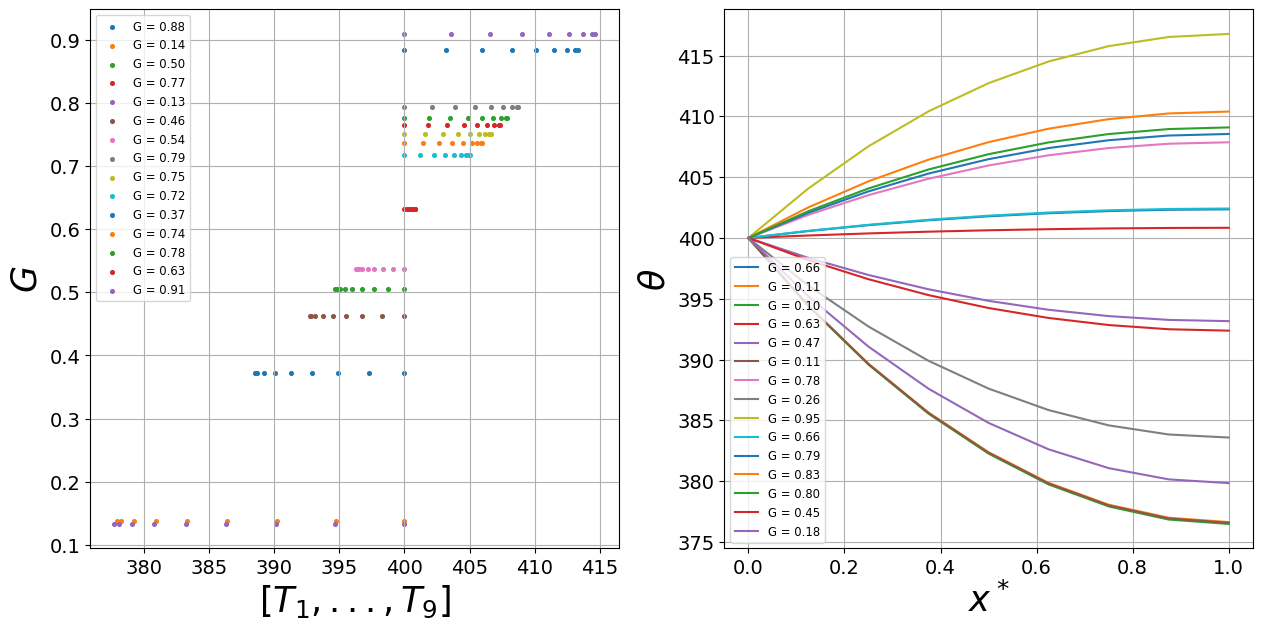

In [ ]:
# Funciones para generar gráficos
def plot_data_vs_G(X_train, Y_train, fig_name, num_sample_plots=15, label_size=14, marker_size=5):
    """
    Function to plot temperature profiles and G values.

    Parameters:
      X_train (ndarray):      X training data set (samples x features).
      Y_train (ndarray):      Y target data set (samples x 1 or samples,).
      fig_name (str):         Full path of figure file to save (e.g., './figs/plot.png').
      num_sample_plots (int): Number of samples to plot.
      label_size (int):       Label font size.
      marker_size (int):      Marker size.
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))

    # Ensure Y_train is 1D
    Y_train = Y_train.flatten()
    aux_ones = np.ones(X_train.shape[1])
    samples_plotted = []

    # First plot: scatter of [theta_1,...,theta_9] vs G
    while len(samples_plotted) < num_sample_plots:
        sample_picked = np.random.randint(0, X_train.shape[0])
        if sample_picked not in samples_plotted:
            G_sample = Y_train[sample_picked].item()
            Y_plot = G_sample * aux_ones
            label = f'G = {G_sample:.2f}'
            ax[0].scatter(X_train[sample_picked, :], Y_plot, label=label, s=marker_size + 2)
            samples_plotted.append(sample_picked)

    ax[0].set_xlabel(r'$[\theta_1,...,\theta_9]$' if X_train.mean() <= 10 else r'$[T_1,...,T_9]$', fontsize=1.8 * label_size)
    ax[0].set_ylabel(r'$G$', fontsize=1.8 * label_size)
    ax[0].tick_params(axis='both', which='major', labelsize=label_size)
    ax[0].legend(fontsize=0.6 * label_size)
    ax[0].grid(True, which="both", ls="-")

    # Second plot: theta vs x
    samples_plotted = []
    aux_x = np.linspace(0, 1, X_train.shape[1])

    while len(samples_plotted) < num_sample_plots:
        sample_picked = np.random.randint(0, X_train.shape[0])
        if sample_picked not in samples_plotted:
            G_sample = Y_train[sample_picked].item()
            label = f'G = {G_sample:.2f}'
            ax[1].plot(aux_x, X_train[sample_picked, :], label=label)
            samples_plotted.append(sample_picked)

    ax[1].set_ylabel(r'$\theta$', fontsize=1.8 * label_size)
    ax[1].set_xlabel(r'$x^*$', fontsize=1.8 * label_size)
    ax[1].tick_params(axis='both', which='major', labelsize=label_size)
    ax[1].legend(fontsize=0.6 * label_size)
    ax[1].grid(True, which="both", ls="-")

    # Ensure directory exists before saving
    save_dir = os.path.dirname(fig_name)
    if save_dir != '':
        os.makedirs(save_dir, exist_ok=True)

    fig.savefig(fig_name, bbox_inches='tight')
    plt.show()

plot_data_vs_G(X_train, Y_train, '/content/drive/MyDrive/Taller PINNs/Clase_3/T_vs_G.png')

## Determino $\theta$ a partir el set de datos X_train y defino el conjunto de muestreo

In [ ]:
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_train = (X_train - T_inf) / (T_b - T_inf)
Theta_test = (X_test - T_inf) / (T_b - T_inf)

# Determino máximo y mínimo del conjunto de datos $\theta$
min_theta, max_theta = max_min_by_columns(Theta_train)

# Opero sobre el conjunto de muestreo del set de datos de entrenamiento
num_data_training = 200

X_train_reduced = Theta_train[:num_data_training,1:] # Remuevo la primer columna de theta ya que no agrega información extra (condición de borde)
Y_train_reduced = Y_train[:num_data_training]

# Determino dimension de la entrada y de la salida
num_col_Xr = X_train_reduced.shape[1]
num_col_Y = Y_train_reduced.shape[1]

# Normalizo la versión reducida de los datos
min_theta_reduced, max_theta_reduced = max_min_by_columns(X_train_reduced)
Xnorm_reduced_train = normalize(X_train_reduced, min_theta_reduced, max_theta_reduced)
print(Xnorm_reduced_train.min(), Xnorm_reduced_train.max())

-1.0 1.0


## Preparo datos para entrenamiento de la red

In [ ]:
# Genero los tensores para entrenamiento
X_train_tensor = torch.tensor(Xnorm_reduced_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train_reduced, dtype=torch.float32)

print("Información de entrenamiento:")
print("X_train normalizado tiene tamaño", Xnorm_reduced_train.shape)
print("Y_train normalizado tiene tamaño", Y_train_reduced.shape)

Información de entrenamiento:
X_train normalizado tiene tamaño (200, 8)
Y_train normalizado tiene tamaño (200, 1)


## Creo la FFNN

In [ ]:
class DNN(nn.Module):
    def __init__(self, layers, activation_fn=None):
        """
        Fully-connected feedforward neural network.

        Parameters:
            layers (list): List of layer sizes [input_dim, ..., output_dim].
            activation_fn (nn.Module): Activation function (default: Tanh).
        """
        super(DNN, self).__init__()

        if activation_fn is None:
            self.activation_fn = nn.Tanh()
        else:
            self.activation_fn = activation_fn


        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])

        # Xavier initialization
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.linears[:-1]:
            x = self.activation_fn(layer(x))
        return self.linears[-1](x)

## Modelo subrrogado

In [ ]:
class surrogate_finn(nn.Module):
    def __init__(self, layers, activation_fn):
        super(surrogate_finn, self).__init__()
        """
        Build, train, and test a neural network model.
        """
        # Build model
        self.model = DNN(layers, activation_fn=activation_fn)
        self.loss_fn = nn.MSELoss(reduction='mean')
        self.loss_history = {"Total": []}

    def forward(self, X):
        return self.model(X)

    def loss(self, X_train, y_train, save=False):
        y_pred = self.forward(X_train)
        loss = self.loss_fn(y_train, y_pred)
        if save:
            self.loss_history["Total"].append(loss.item())
        return loss

## Funciones de creación de imágenes

In [ ]:
def plot_loss_history(model):
    if len(model.loss_history['Total']) == 0:
        print('No hay pérdidas todavía')
        return  # No hay datos todavía, no grafiques

    epochs = range(len(model.loss_history['Total']))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, model.loss_history['Total'], label='Total Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.title('Training Loss Evolution')
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

## Parámetros de entrenamiento

In [ ]:
n_iter_adam = 5000
learning_rate_adam = 1e-4
nneurons = 32
nhiden_layers = 2
activation_fn = nn.LeakyReLU()
input_dim = num_col_Xr
output_dim = num_col_Y
layers_finn = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])

print("[INFO] Estructura de la red PINN:")
print(f"  - Capa de entrada: {input_dim} nodos")
print(f"  - Capas ocultas: {nhiden_layers} capas de {nneurons} neuronas cada una")
print(f"  - Capa de salida: {output_dim} nodos")
print(f"  - Arquitectura total: {layers_finn.tolist()}")

[INFO] Estructura de la red PINN:
  - Capa de entrada: 8 nodos
  - Capas ocultas: 2 capas de 32 neuronas cada una
  - Capa de salida: 1 nodos
  - Arquitectura total: [8, 32, 32, 1]


## Entrenamiento

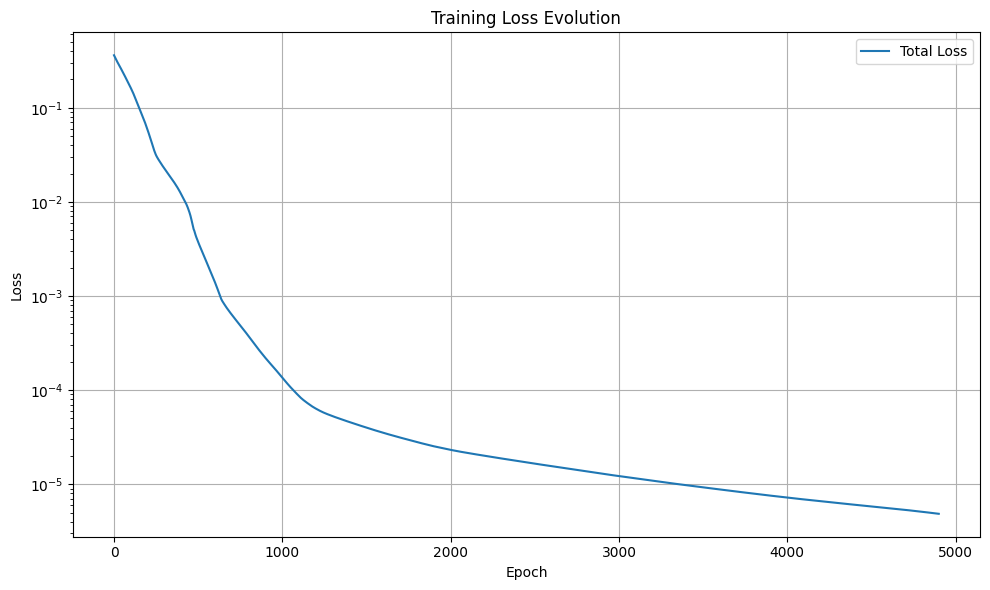

[Epoch 4900] Loss Total: 4.8544e-06
Tiempo total de entrenamiento 38.908758878707886


In [ ]:
# === Inicialización del modelo y optimizadores ===
model = surrogate_finn(layers=layers_finn, activation_fn=activation_fn)
print('Training NN')
start_time = time.time()

# Separar parámetros de red y lambdas (CORREGIDO: incluir lambda_bc)
params_model = list(model.model.parameters())

# Optimizers
optimizer_model = torch.optim.Adam(params_model, lr=learning_rate_adam, amsgrad=True, betas=(0.9, 0.999))

# === Entrenamiento con ADAM ===
for epoch in range(n_iter_adam):
    optimizer_model.zero_grad()

    loss_total = model.loss(
        X_train_tensor, y_train_tensor,
        save=True)

    loss_total.backward()
    optimizer_model.step()

    if epoch % 100 == 0:
        clear_output(wait=True)
        plot_loss_history(model)
        print(f"[Epoch {epoch:04d}] Loss Total: {loss_total.item():.4e}")

# Consumed time
elapsed_time = time.time() - start_time
print('Tiempo total de entrenamiento', elapsed_time)

## Valido predicción con datos de prueba

Tamaño de X de prueba (100, 8)
Tamaño de Y de prueba (100, 1)
MSE Test: 5.6498e-06
MSE Train: 4.6137e-06


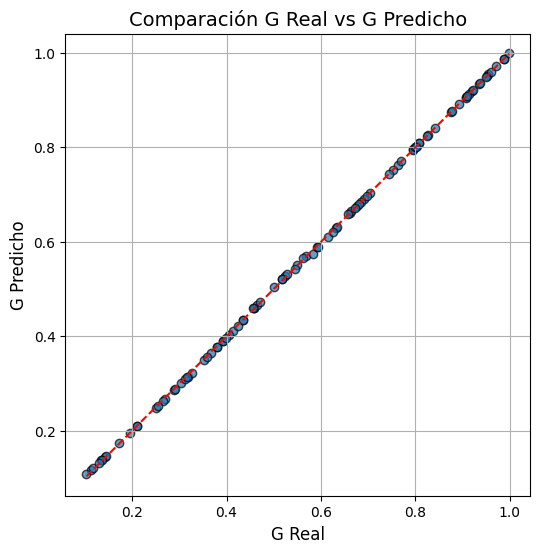

In [ ]:
# === 1. Preprocesamiento de test ===
Theta_test = (X_test - T_inf) / (T_b - T_inf)
X_test_reduced = Theta_test[:,1:]
Y_test_reduced = Y_test

print('Tamaño de X de prueba', X_test_reduced.shape)
print('Tamaño de Y de prueba', Y_test_reduced.shape)

# Normalización igual que el conjunto de entrenamiento reducido
Xnorm_reduced_test = normalize(X_test_reduced, min_theta_reduced, max_theta_reduced)

# Conversión a tensor
Xnorm_test_tensor = torch.tensor(Xnorm_reduced_test, dtype=torch.float32)

# Evaluación de la red ===
model.eval()
with torch.no_grad():
    y_pred_test = model(Xnorm_test_tensor).cpu().numpy()

# Cálculo del error ===
mse_test = np.mean((y_pred_test - Y_test_reduced)**2)
print(f"MSE Test: {mse_test:.4e}")

# Comparar con entrenamiento ===
y_pred_train = model(torch.tensor(Xnorm_reduced_train, dtype=torch.float32)).detach().numpy()
mse_train = np.mean((y_pred_train - Y_train_reduced)**2)
print(f"MSE Train: {mse_train:.4e}")

plt.figure(figsize=(6, 6))
plt.scatter(Y_test, y_pred_test, alpha=0.7, edgecolors='k')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # línea ideal
plt.xlabel('G Real', fontsize=12)
plt.ylabel('G Predicho', fontsize=12)
plt.title('Comparación G Real vs G Predicho', fontsize=14)
plt.grid(True)
plt.axis('equal')
plt.show()